# Section 1: Data Preprocess

In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('titanic_augmented.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


## Section 1.1: Cabin and Age Data

From the dataset, we observe that approximately 75% of the observations have missing values for the Cabin variable.
However, the data provider has already performed preprocessing by aggregating cabin-related information into the cabin_score feature.
Therefore, we use cabin_score together with a newly created cabin_missing indicator to represent cabin-related information in the analysis.

We also observe that a substantial number of passengers have missing values for Age.
Therefore, we create a new binary variable, age_missing, to explicitly capture this information.

In [4]:
len(data[data["Cabin"].isna()])

687

In [5]:
data[data["Cabin"].notna() & data['Age'].isna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,...,0,2,73.260,0.0,B,78.0,41405837,521909,6.061746,6
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,...,1,1,35.500,0.0,C,52.0,76343490,356840,5.899177,3
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,...,0,2,11.179,0.0,F,69.0,70214072,788519,2.692432,3
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,...,0,2,27.500,0.0,E,33.0,20531130,318126,1.120389,5
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,...,1,1,50.000,0.0,A,32.0,98227178,874684,6.106200,4


We can see from the dataset that there are 687 people missing Cabin information. Therefore, we decide to process the cabin information first.

In [6]:
data["Age_missing"] = data["Age"].isna()
data["Cabin_missing"] = data["Cabin"].isna()
fare_mean_table = pd.pivot_table(
    data,
    values="fare_per_person",
    index="Age_missing",
    columns="Cabin_missing",
    aggfunc="mean"
)

fare_mean_table

Cabin_missing,False,True
Age_missing,,
False,39.542481,11.450115
True,40.288526,10.835747


Given the histogram of the age column, we decide to fill the missing age data with age mean, since it is almost normally distributed.

<Axes: >

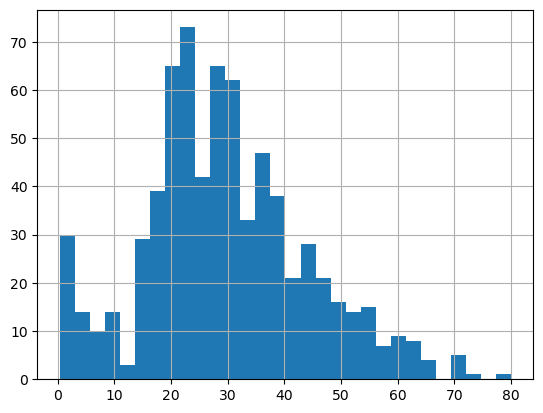

In [7]:
data['Age'].hist(bins=30)

In [8]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [9]:
import altair as alt
alt.Chart(data).mark_bar(opacity=0.7).encode(
    x=alt.X(
        "Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count"),
    color=alt.Color(
        "Cabin_missing:N",
        title="Cabin Missing",
        scale=alt.Scale(scheme="set1")
    )
).properties(
    width=500,
    height=350,
    title="Fare Distribution by Cabin Missingness"
)


alt.Chart(...)

Note that we can see from the dataframe that passengers with Cabin information tend to pay a higher ticket price

## Section 1.2: Quantitative Data Normalization

We observe that the distributions of Fare, fare_per_person, and age_fare_ratio are highly right-skewed.
Therefore, we apply a logarithmic transformation to these variables in order to reduce skewness and make the distributions more approximately normal.

In [10]:
fare_hist = alt.Chart(data).mark_bar().encode(
    x=alt.X(
        "Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare"
)

fpp_hist = alt.Chart(data[data["fare_per_person"].notna()]).mark_bar().encode(
    x=alt.X(
        "fare_per_person:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare per Person"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare per Person"
)

afr_hist = alt.Chart(data[data["age_fare_ratio"].notna()]).mark_bar().encode(
    x=alt.X(
        "age_fare_ratio:Q",
        bin=alt.Bin(maxbins=40),
        title="Age / Fare Ratio"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Age–Fare Ratio"
)

(fare_hist | fpp_hist | afr_hist).resolve_scale(
    y="independent"
)

alt.HConcatChart(...)

In [11]:
import numpy as np
data["log_Fare"] = np.log1p(data["Fare"])
data["log_fare_per_person"] = np.log1p(data["fare_per_person"])
data["log_age_fare_ratio"] = np.log1p(data["age_fare_ratio"])

In [12]:
fare_hist = alt.Chart(data).mark_bar().encode(
    x=alt.X(
        "log_Fare:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare"
)

fpp_hist = alt.Chart(data[data["fare_per_person"].notna()]).mark_bar().encode(
    x=alt.X(
        "log_fare_per_person:Q",
        bin=alt.Bin(maxbins=40),
        title="Fare per Person"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Fare per Person"
)

afr_hist = alt.Chart(data[data["age_fare_ratio"].notna()]).mark_bar().encode(
    x=alt.X(
        "log_age_fare_ratio:Q",
        bin=alt.Bin(maxbins=40),
        title="Age / Fare Ratio"
    ),
    y=alt.Y("count()", title="Count")
).properties(
    width=280,
    height=300,
    title="Age–Fare Ratio"
)

(fare_hist | fpp_hist | afr_hist).resolve_scale(
    y="independent"
)

alt.HConcatChart(...)

## Section 1.4: Dropping Uneccesary Columns:

We keep cabin_score and cabin_missing as the sole representations of cabin-related information and drop all remaining cabin variables.
Furthermore, we remove the original (untransformed) variables Fare, fare_per_person, and age_fare_ratio, along with identifier variables such as PassengerID, Name, Ticket, service_id, and booking_reference, as these features do not carry predictive value and may lead to data leakage.

Given the title and title_group variables, we retain both columns for the time being.
The choice of which variable to use will be left to individual group members’ modeling decisions.
Note that title_group is a compressed version of the original title variable.

In [13]:
data=data.drop(columns=['PassengerId','Fare','fare_per_person','age_fare_ratio','Name','Ticket','service_id','booking_reference','Cabin','cabin_deck','cabin_room_number'])

In [14]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,0,3,male,22.000000,1,0,S,23,Mr,Mr,2,0,1,6.134152,4,False,True,2.110213,2.110213,1.394878
1,1,1,female,38.000000,1,0,C,51,Mrs,Mrs,2,0,1,4.182430,7,False,False,4.280593,4.280589,0.427282
2,1,3,female,26.000000,0,0,S,22,Miss,Miss,1,1,1,9.327285,3,False,True,2.188856,2.188856,1.454130
3,1,1,female,35.000000,1,0,S,44,Mrs,Mrs,2,0,2,8.660639,7,False,False,3.990834,3.316003,0.506296
4,0,3,male,35.000000,0,0,S,24,Mr,Mr,1,1,1,0.452187,4,False,True,2.202765,2.202765,1.676690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,S,21,Rev,Other,1,1,1,4.308875,3,False,True,2.639057,2.639057,1.123930
887,1,1,female,19.000000,0,0,S,28,Miss,Miss,1,1,1,2.487143,4,False,False,3.433987,3.433987,0.490623
888,0,3,female,29.699118,1,2,S,40,Miss,Miss,4,0,2,6.171450,5,True,True,3.196630,2.543569,0.000000
889,1,1,male,26.000000,0,0,C,21,Mr,Mr,1,1,1,7.067772,4,False,False,3.433987,3.433987,0.624154


In [15]:
data.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'name_length', 'title', 'title_group', 'family_size', 'is_alone',
       'ticket_group_size', 'cabin_score', 'name_word_count', 'Age_missing',
       'Cabin_missing', 'log_Fare', 'log_fare_per_person',
       'log_age_fare_ratio'],
      dtype='object')

## Section 1.5: Exporting Training and Testing Dataset

In [16]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(
    data,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=data["Survived"]
)

train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)

# Section 2: Logistic Regression

In [17]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [18]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.000000,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.000000,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.000000,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.000000,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.000000,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,2,male,29.699118,0,0,C,26,Mr,Mr,1,1,1,4.019309,5,True,True,2.698841,2.698808,0.000000
664,1,3,female,0.750000,2,1,C,29,Miss,Miss,4,0,4,5.968428,4,False,True,3.008565,1.760441,0.038205
665,0,3,female,48.000000,1,3,S,39,Mrs,Mrs,5,0,4,1.312449,6,False,True,3.566005,2.261138,0.873952
666,0,1,male,47.000000,0,0,S,17,Mr,Mr,1,1,1,7.325721,4,False,False,3.676301,3.676301,0.797858


In [19]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'name_length', 'title', 'title_group', 'family_size', 'is_alone',
       'ticket_group_size', 'cabin_score', 'name_word_count', 'Age_missing',
       'Cabin_missing', 'log_Fare', 'log_fare_per_person',
       'log_age_fare_ratio'],
      dtype='object')

## Backward Stepwise Selection
We started with a relatively large set of engineered features (demographic variables, ticket/family structure variables, and missingness indicators). A full logistic regression model with many correlated predictors can be difficult to interpret and may overfit, especially when several features capture similar information (e.g., family-related variables, multiple fare transformations). Therefore, we used backward stepwise selection to obtain a more parsimonious model that preserves predictive signal while improving interpretability.

In [20]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
formula_full = """
Survived ~ 
Pclass + Age + SibSp + Parch +
name_length + family_size + ticket_group_size +
cabin_score + name_word_count +
Age_missing + Cabin_missing +
log_Fare + log_fare_per_person + log_age_fare_ratio +
is_alone +
C(Sex) + C(Embarked) + C(title_group)
"""
full_model = smf.glm(
    formula=formula_full,
    data=train,
    family=sm.families.Binomial()
).fit()

print(full_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  666
Model:                            GLM   Df Residuals:                      644
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -262.57
Date:                Fri, 06 Feb 2026   Deviance:                       525.14
Time:                        19:53:26   Pearson chi2:                     671.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.4178
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Standard implementations of stepwise selection in statsmodels rely on single-sample AIC, which evaluates model fit using the same data on which parameters are estimated. While this is computationally convenient, it can lead to overly optimistic variable selection, particularly when predictors are correlated or when extensive feature engineering has been performed.

Because statsmodels does not provide a built-in stepwise procedure with cross-validation, we implemented a custom backward stepwise function. This allows us to explicitly control how predictors are evaluated and to integrate K-fold cross-validation directly into the model selection criterion.

## Incorporating K-fold cross-validation into AIC

The key idea is to replace the single-sample AIC with a cross-validated AIC. For a given candidate model, the procedure is:

Split the training data into K folds (using stratification when the response is binary).

For each fold:

Fit the GLM on the remaining K−1 folds.

Evaluate the fitted model on the held-out fold by computing the log-likelihood of the validation data.

Convert this validation log-likelihood into an AIC value using

$$AIC=2k−2ℓ$$,

where 
k is the number of model parameters and 
ℓ is the validation log-likelihood.

Average the fold-level AIC values to obtain a mean CV-AIC for the candidate model.

By evaluating the likelihood on held-out data, CV-AIC provides a more realistic estimate of out-of-sample performance than standard AIC.

In [21]:
def backward_stepwise_aic(data, response, predictors, k=5, seed=42, tol=1e-6, verbose=True):
    """
    Drop-in replacement:
    Backward stepwise selection using K-fold CV AIC (lower is better).

    Returns:
      final_model (fit on full data with selected predictors),
      remaining (selected predictor terms)
    """
    import numpy as np
    import pandas as pd
    import patsy

    remaining = predictors.copy()
    if len(remaining) == 0:
        raise ValueError("predictors is empty.")

    rng = np.random.default_rng(seed)
    y = data[response].astype(int).values
    n = len(data)
    idx = np.arange(n)

    # Stratified folds for binary response if possible
    unique_y = np.unique(y[~pd.isna(y)])
    fold_id = np.empty(n, dtype=int)

    if len(unique_y) == 2:
        for cls in unique_y:
            cls_idx = idx[y == cls]
            rng.shuffle(cls_idx)
            fold_id[cls_idx] = np.arange(len(cls_idx)) % k
    else:
        rng.shuffle(idx)
        fold_id[idx] = np.arange(n) % k

    def _fit_glm(train_df, formula):
        return smf.glm(formula=formula, data=train_df, family=sm.families.Binomial()).fit()

    def _cv_mean_aic(terms):
        formula = response + " ~ " + " + ".join(terms)

        fold_aics = []
        for f in range(k):
            train_df = data[fold_id != f]
            valid_df = data[fold_id == f]

            m = _fit_glm(train_df, formula)

            # Build validation design matrices using the same formula
            y_valid, X_valid = patsy.dmatrices(formula, valid_df, return_type="dataframe")

            # Linear predictor on validation fold
            eta = np.asarray(X_valid @ m.params)

            # Mean mu on validation fold (inverse link)
            mu = m.family.link.inverse(eta)

            # Validation log-likelihood (sum over obs)
            ll_obs = m.family.loglike_obs(y_valid.values.ravel(), mu)
            ll = float(np.sum(ll_obs))

            # k parameters = df_model + 1 (include intercept)
            n_params = int(m.df_model) + 1

            # AIC on validation fold
            aic = 2 * n_params - 2 * ll
            fold_aics.append(aic)

        return float(np.mean(fold_aics)), float(np.std(fold_aics))

    # Initial CV-AIC
    best_mean_aic, best_std_aic = _cv_mean_aic(remaining)
    if verbose:
        print(f"Start CV-AIC: {best_mean_aic:.2f} ± {best_std_aic:.2f}  (k={k})")

    while True:
        candidates = []
        for var in remaining:
            trial_terms = [t for t in remaining if t != var]
            if len(trial_terms) == 0:
                continue
            mean_aic, std_aic = _cv_mean_aic(trial_terms)
            candidates.append((mean_aic, std_aic, var, trial_terms))

        if not candidates:
            if verbose:
                print("No candidates to test. Stop.")
            break

        candidates.sort(key=lambda x: x[0])  # lower is better
        trial_mean, trial_std, removed_var, trial_terms = candidates[0]

        if trial_mean < best_mean_aic - tol:
            if verbose:
                print(f"Remove: {removed_var:25s} | CV-AIC {best_mean_aic:.2f} → {trial_mean:.2f}")
            remaining = trial_terms
            best_mean_aic, best_std_aic = trial_mean, trial_std
        else:
            if verbose:
                print("No CV-AIC improvement. Stop.")
            break

    # Fit final model on full data
    final_formula = response + " ~ " + " + ".join(remaining)
    final_model = smf.glm(formula=final_formula, data=data, family=sm.families.Binomial()).fit()

    return final_model, remaining


In [22]:
predictors = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "family_size", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)"
]


## Model Training

In [23]:
best_model, selected_vars = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors,
    k=5
)


Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 152.91
Remove: C(Embarked)               | CV-AIC 152.91 → 148.97
Remove: is_alone                  | CV-AIC 148.97 → 145.46
Remove: ticket_group_size         | CV-AIC 145.46 → 142.59
Remove: log_Fare                  | CV-AIC 142.59 → 140.41
Remove: name_word_count           | CV-AIC 140.41 → 138.47
Remove: name_length               | CV-AIC 138.47 → 136.59
Remove: log_age_fare_ratio        | CV-AIC 136.59 → 134.99
Remove: Age_missing               | CV-AIC 134.99 → 132.86
Remove: cabin_score               | CV-AIC 132.86 → 131.42
Remove: log_fare_per_person       | CV-AIC 131.42 → 130.06
Remove: Cabin_missing             | CV-AIC 130.06 → 129.85
No CV-AIC improvement. Stop.


In [24]:
print(best_model.summary())
print("\nSelected variables:")
selected_vars

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  668
Model:                            GLM   Df Residuals:                      662
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -290.91
Date:                Fri, 06 Feb 2026   Deviance:                       581.82
Time:                        19:54:09   Pearson chi2:                     676.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3689
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0970      0.434      9.

['Pclass', 'Age', 'SibSp', 'Parch', 'family_size', 'C(Sex)']

In [25]:
params = best_model.params
conf = best_model.conf_int()
conf.columns = ["lower", "upper"]

or_df = pd.DataFrame({
    "OR": np.exp(params),
    "lower": np.exp(conf["lower"]),
    "upper": np.exp(conf["upper"])
})

or_df = or_df.drop("Intercept")
or_df

,OR,lower,upper
C(Sex)[T.male],0.063042,0.040045,0.099246
Pclass,0.297948,0.226035,0.392741
Age,0.958304,0.941495,0.975414
SibSp,0.217247,0.148661,0.317476
Parch,0.268746,0.188773,0.382599
family_size,3.512410,2.703306,4.563681


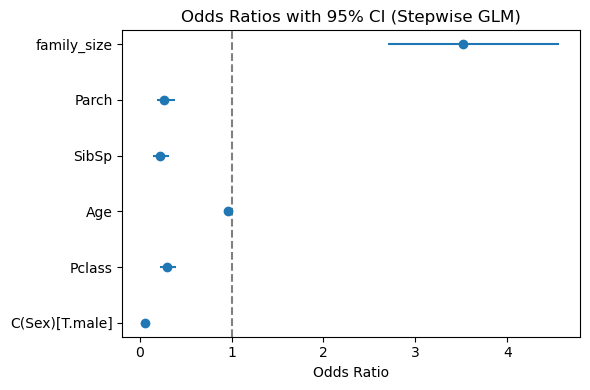

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

y_pos = range(len(or_df))
plt.errorbar(
    or_df["OR"], y_pos,
    xerr=[or_df["OR"] - or_df["lower"], or_df["upper"] - or_df["OR"]],
    fmt="o"
)

plt.axvline(1, color="grey", linestyle="--")
plt.yticks(y_pos, or_df.index)
plt.xlabel("Odds Ratio")
plt.title("Odds Ratios with 95% CI (Stepwise GLM)")
plt.tight_layout()
plt.show()

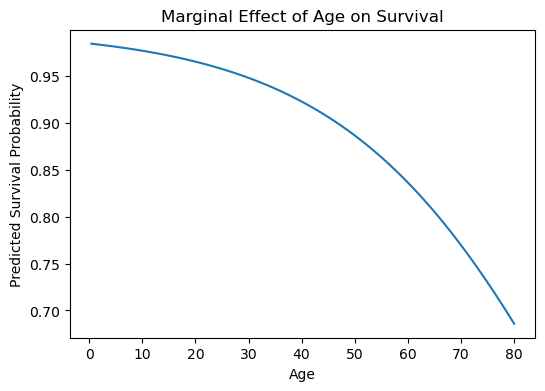

In [27]:
age_grid = np.linspace(train.Age.min(), train.Age.max(), 100)

ref = train.median(numeric_only=True)
ref["Sex"] = "female"
ref["Pclass"] = 2
ref["family_size"] = 2
ref["SibSp"] = 0
ref["Parch"] = 0

pred_df = pd.DataFrame({
    "Age": age_grid,
    "Sex": ref["Sex"],
    "Pclass": ref["Pclass"],
    "family_size": ref["family_size"],
    "SibSp": ref["SibSp"],
    "Parch": ref["Parch"]
})

pred_prob = best_model.predict(pred_df)

plt.figure(figsize=(6,4))
plt.plot(age_grid, pred_prob)
plt.xlabel("Age")
plt.ylabel("Predicted Survival Probability")
plt.title("Marginal Effect of Age on Survival")
plt.show()


This figure shows the marginal effect of age on the predicted probability of survival, holding all other variables constant at representative values.

## Model Performance on Test Set

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict probabilities
y_prob = best_model.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.7803

Confusion Matrix:
        Pred 0  Pred 1
True 0     112      25
True 1      24      62

Classification Report:
              precision    recall  f1-score   support

           0     0.8235    0.8175    0.8205       137
           1     0.7126    0.7209    0.7168        86

    accuracy                         0.7803       223
   macro avg     0.7681    0.7692    0.7686       223
weighted avg     0.7808    0.7803    0.7805       223



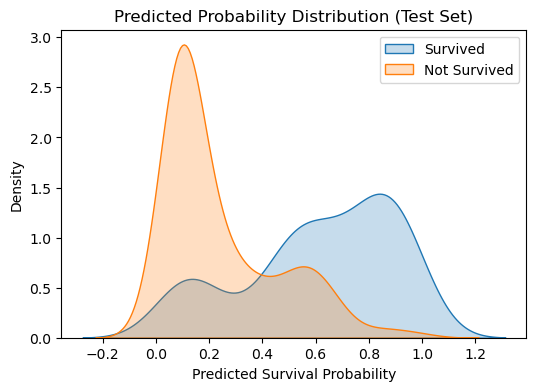

In [29]:
import seaborn as sns

test = test.copy()
test["pred_prob"] = best_model.predict(test)

plt.figure(figsize=(6,4))
sns.kdeplot(test.loc[test.Survived == 1, "pred_prob"], label="Survived", fill=True)
sns.kdeplot(test.loc[test.Survived == 0, "pred_prob"], label="Not Survived", fill=True)

plt.xlabel("Predicted Survival Probability")
plt.title("Predicted Probability Distribution (Test Set)")
plt.legend()
plt.show()

In [30]:
test["pred_prob"]

0      0.089412
1      0.695598
2      0.118147
3      0.612048
4      0.042825
         ...   
218    0.677973
219    0.130682
220    0.899682
221    0.125919
222    0.070539
Name: pred_prob, Length: 223, dtype: float64

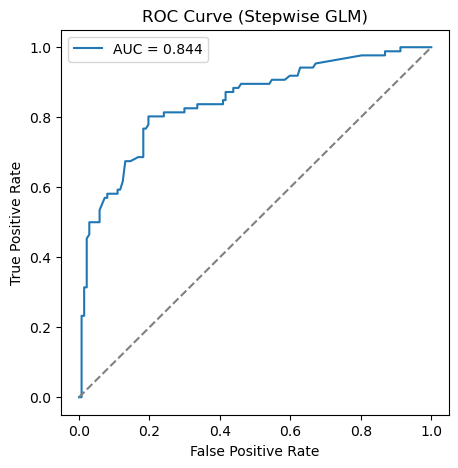

In [31]:
from sklearn.metrics import roc_curve, auc

y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

The ROC curve shows strong discriminative performance, with an AUC of 0.844, indicating that the stepwise GLM can effectively distinguish between survivors and non-survivors.

## Further Improvement

By examining the misclassified samples, we observe that several passengers with the title Master are incorrectly predicted. This is expected, as without explicitly modeling the Master title, the model tends to treat these passengers as adult males, who have a lower survival probability. In addition, the effect of age alone is relatively weak (with an odds ratio close to 1), which prevents the model from adequately correcting this bias, leading to misclassification.

In [32]:
test_eval = test.copy()
test_eval["y_true"] = y_true
test_eval["y_pred"] = y_pred
test_eval["y_prob"] = y_prob

misclassified = test_eval[test_eval["y_true"] != test_eval["y_pred"]]

print(f"Number of misclassified samples: {len(misclassified)}")
misclassified[misclassified['Survived']==1]


Number of misclassified samples: 49


,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,...,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio,pred_prob,y_true,y_pred,y_prob
19,1,3,male,25.000000,0,0,S,28,Mr,Mr,...,4,False,True,0.000000,0.000000,0.000000,0.108332,1,0,0.108332
25,1,3,male,27.000000,0,0,S,44,Mr,Mr,...,5,False,True,2.174274,2.174297,1.495912,0.100374,1,0,0.100374
26,1,2,male,8.000000,1,1,S,30,Master,Master,...,5,False,True,3.630985,2.963984,0.196953,0.377274,1,0,0.377274
29,1,1,male,31.000000,1,0,S,23,Mr,Mr,...,4,False,False,4.060443,3.384390,0.434286,0.447154,1,0,0.447154
34,1,1,male,35.000000,0,0,S,32,Mr,Mr,...,4,False,False,3.306429,3.306447,0.846482,0.472000,1,0,0.472000
48,1,3,male,18.000000,0,0,S,24,Mr,Mr,...,4,False,True,2.202765,2.202765,1.174346,0.140667,1,0,0.140667
51,1,3,male,9.000000,1,1,S,37,Master,Master,...,5,False,True,2.827314,2.191654,0.448549,0.147473,1,0,0.147473
54,1,3,male,29.699118,0,0,S,33,Mr,Mr,...,3,True,True,2.209647,2.209702,0.000000,0.090460,1,0,0.090460
63,1,3,male,29.699118,0,0,S,15,Mr,Mr,...,3,True,True,4.051712,2.205083,0.000000,0.090460,1,0,0.090460
88,1,2,male,62.000000,0,0,S,18,Mr,Mr,...,3,False,True,2.442347,2.442347,1.932211,0.077782,1,0,0.077782


Therefore, we decide to add a new column `Master` and retrain the model.

In [33]:
train['Master'] = (train['title'] == 'Master').astype(int)
test['Master'] = (test['title'] == 'Master').astype(int)

In [34]:
predictors_ver2 = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "family_size", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)", "Master"
]

In [35]:
best_model_ver2, selected_vars_ver2 = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors_ver2,
    k=5
)

Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 151.36
Remove: C(Embarked)               | CV-AIC 151.36 → 147.19
Remove: is_alone                  | CV-AIC 147.19 → 143.35
Remove: ticket_group_size         | CV-AIC 143.35 → 140.17
Remove: log_age_fare_ratio        | CV-AIC 140.17 → 137.80
Remove: log_fare_per_person       | CV-AIC 137.80 → 135.47
Remove: Age_missing               | CV-AIC 135.47 → 133.19
Remove: name_length               | CV-AIC 133.19 → 131.17
Remove: name_word_count           | CV-AIC 131.17 → 129.16
Remove: cabin_score               | CV-AIC 129.16 → 127.64
Remove: log_Fare                  | CV-AIC 127.64 → 126.41
Remove: Age                       | CV-AIC 126.41 → 125.74
Remove: Cabin_missing             | CV-AIC 125.74 → 125.02
No CV-AIC improvement. Stop.


In [36]:
print(best_model_ver2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  668
Model:                            GLM   Df Residuals:                      662
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.27
Date:                Fri, 06 Feb 2026   Deviance:                       558.53
Time:                        19:55:03   Pearson chi2:                     708.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3905
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.1874      0.315     10.

In [37]:
y_prob = best_model_ver2.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.8296

Confusion Matrix:
        Pred 0  Pred 1
True 0     122      15
True 1      23      63

Classification Report:
              precision    recall  f1-score   support

           0     0.8414    0.8905    0.8652       137
           1     0.8077    0.7326    0.7683        86

    accuracy                         0.8296       223
   macro avg     0.8245    0.8115    0.8168       223
weighted avg     0.8284    0.8296    0.8279       223



In [38]:
y_prob

0      0.078958
1      0.700392
2      0.043420
3      0.700392
4      0.006541
         ...   
218    0.846552
219    0.078958
220    0.781033
221    0.078958
222    0.052741
Length: 223, dtype: float64

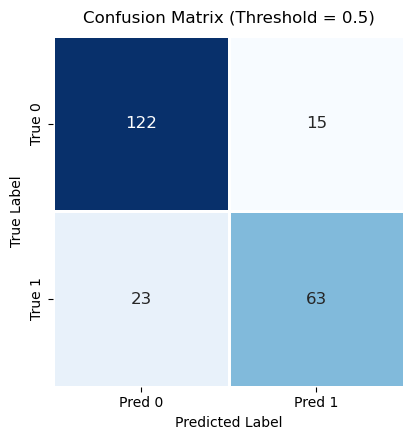

In [39]:
plt.figure(figsize=(4.5, 4.5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    square=True,
    linewidths=1,
    linecolor="white",
    annot_kws={"size": 12}
)

plt.title("Confusion Matrix (Threshold = 0.5)", pad=10)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [40]:
test["pred_prob"]

0      0.089412
1      0.695598
2      0.118147
3      0.612048
4      0.042825
         ...   
218    0.677973
219    0.130682
220    0.899682
221    0.125919
222    0.070539
Name: pred_prob, Length: 223, dtype: float64

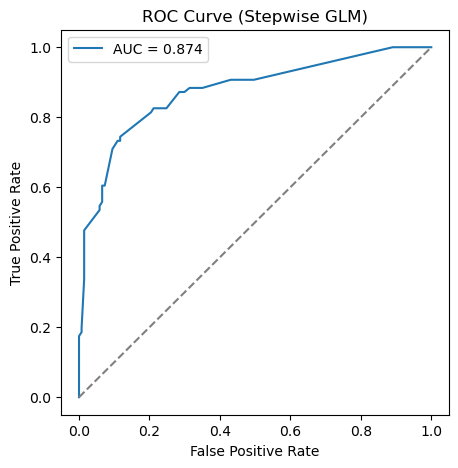

In [41]:
test = test.copy()
test["pred_prob"] = best_model_ver2.predict(test)
y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

## Further Work:

Since SibSp, Parch, and FamilySize exhibit strong collinearity, FamilySize is excluded from the full model to reduce multicollinearity, and the model is subsequently refitted.

In [42]:
predictors_ver3 = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)", "Master"
]
best_model_ver3, selected_vars_ver3 = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors_ver3,
    k=5
)
print(best_model_ver3.summary())

Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 151.36
Remove: C(Embarked)               | CV-AIC 151.36 → 147.19
Remove: is_alone                  | CV-AIC 147.19 → 143.35
Remove: ticket_group_size         | CV-AIC 143.35 → 140.17
Remove: log_age_fare_ratio        | CV-AIC 140.17 → 137.80
Remove: log_fare_per_person       | CV-AIC 137.80 → 135.47
Remove: Age_missing               | CV-AIC 135.47 → 133.19
Remove: name_length               | CV-AIC 133.19 → 131.17
Remove: name_word_count           | CV-AIC 131.17 → 129.16
Remove: cabin_score               | CV-AIC 129.16 → 127.64
Remove: Parch                     | CV-AIC 127.64 → 126.34
Remove: log_Fare                  | CV-AIC 126.34 → 124.71
Remove: Cabin_missing             | CV-AIC 124.71 → 123.99
Remove: Age                       | CV-AIC 123.99 → 123.28
No CV-AIC improvement. Stop.
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Su

In [43]:
y_prob = best_model_ver3.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.8296

Confusion Matrix:
        Pred 0  Pred 1
True 0     122      15
True 1      23      63

Classification Report:
              precision    recall  f1-score   support

           0     0.8414    0.8905    0.8652       137
           1     0.8077    0.7326    0.7683        86

    accuracy                         0.8296       223
   macro avg     0.8245    0.8115    0.8168       223
weighted avg     0.8284    0.8296    0.8279       223



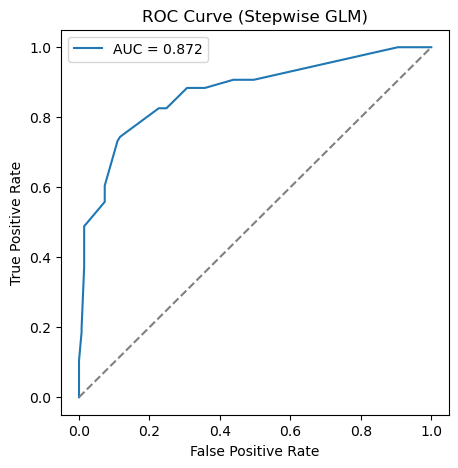

In [44]:
test = test.copy()
test["pred_prob"] = best_model_ver3.predict(test)
y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

## Conclusion

Using backward stepwise selection with cross-validated AIC, we derived a parsimonious logistic regression model for predicting Titanic passenger survival. To address multicollinearity among family-related variables, the derived FamilySize feature was removed, allowing the model to retain SibSp and Parch as distinct and interpretable predictors. In addition, incorporating the passenger title Master enabled the model to distinguish young male passengers from adult males.

The final model includes six statistically significant predictors: sex, passenger class, age, number of siblings/spouses aboard (SibSp), number of parents/children aboard (Parch), and the Master indicator. Despite this simplified specification, the model achieves strong predictive performance, with a test accuracy of 82.96% and an AUC of approximately 0.85, indicating good discriminative ability.

The results are highly interpretable and consistent with historical context. Male passengers and lower passenger classes are associated with reduced survival odds, while younger age and family-related covariates provide protective effects. Importantly, distinguishing Master passengers corrects a systematic bias in the baseline model that previously underestimated survival probabilities for young males. Overall, the final GLM effectively balances interpretability, robustness, and predictive performance, making it suitable for both statistical inference and practical risk assessment.

# Section 2: KNN

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [46]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.000000,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.000000,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.000000,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.000000,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.000000,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,2,male,29.699118,0,0,C,26,Mr,Mr,1,1,1,4.019309,5,True,True,2.698841,2.698808,0.000000
664,1,3,female,0.750000,2,1,C,29,Miss,Miss,4,0,4,5.968428,4,False,True,3.008565,1.760441,0.038205
665,0,3,female,48.000000,1,3,S,39,Mrs,Mrs,5,0,4,1.312449,6,False,True,3.566005,2.261138,0.873952
666,0,1,male,47.000000,0,0,S,17,Mr,Mr,1,1,1,7.325721,4,False,False,3.676301,3.676301,0.797858


In [47]:
train["is_master"] = (train["title"].str.lower() == "master").astype(int)
test["is_master"]  = (test["title"].str.lower() == "master").astype(int)
train["is_child"] = (train["Age"] < 12).astype(int)
test["is_child"] = (test["Age"] < 12).astype(int)

In [48]:
train_analysis = train.copy()
le = LabelEncoder()
train_analysis['Sex'] = le.fit_transform(train_analysis['Sex'])

In [49]:
# here i am excluding the target 'Survived' and non-numeric columns
features_to_test = train_analysis.select_dtypes(include=['number']).drop(columns=['Survived'])
X_logic = features_to_test
y_logic = train_analysis['Survived']

In [50]:
#relation betweeen X and Y
importances = mutual_info_classif(X_logic, y_logic, random_state=42)
feat_importances = pd.Series(importances, index=X_logic.columns)

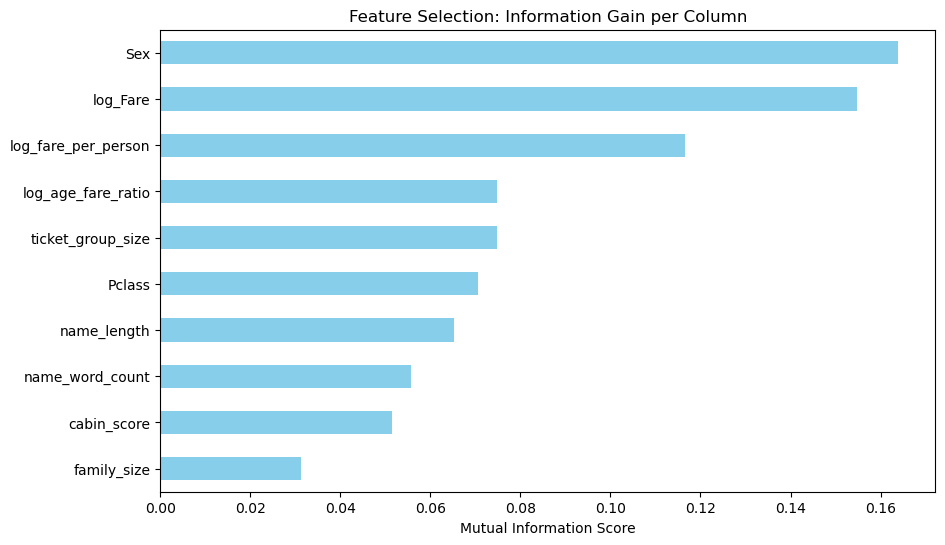

In [51]:
plt.figure(figsize=(10, 6))
feat_importances.sort_values(ascending=True).tail(10).plot(kind='barh', color='skyblue')
plt.title('Feature Selection: Information Gain per Column')
plt.xlabel('Mutual Information Score')
plt.show()

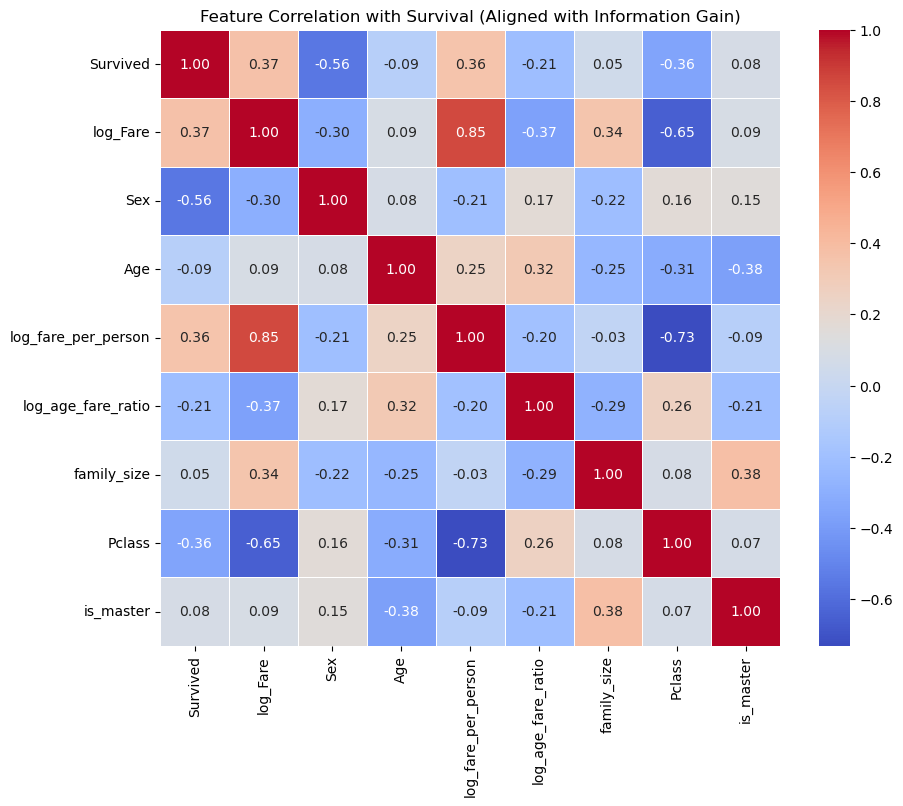

In [52]:
# Correlation Heatmap to visualize relationships between features and target
le = LabelEncoder()
train_corr = train.copy()
train_corr['Sex'] = le.fit_transform(train_corr['Sex'])
validation_features = [
    'Survived', 'log_Fare', 'Sex','Age','log_fare_per_person', 
    'log_age_fare_ratio', 'family_size', 'Pclass', 'is_master'
]

# Create correlation matrix
corr_matrix = train_corr[validation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation with Survival (Aligned with Information Gain)')
plt.show()

In [53]:
# Numerical features
num_features = ["log_Fare", "log_fare_per_person", "log_age_fare_ratio", "family_size", "Pclass", "Age"]
# Binary features
bin_features = ["is_master", "is_child", "is_alone"]
# Categorical features
cat_features = ["Sex", "Embarked", "title_group"]
# Preparing training set
X = train[num_features + bin_features + cat_features]
y = train["Survived"]
# Preparing matching test set
X_test_final = test[num_features + bin_features + cat_features]
y_test_final = test["Survived"]

# Internal split for validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

To avoid data leakage in cross-validation, KNN is wrapped in a pipeline that standardizes features inside each CV fold. A stratified 5-fold split (shuffled, fixed seed) keeps class balance while tuning K, distance metric, and weighting.

In [54]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Preprocessing Pipeline
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()) # Critical for KNN distance math
    ]), num_features),
    ("bin", "passthrough", bin_features),
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

# KNN Model Pipeline
pipe = Pipeline([
    ("prep", preprocess),
    ("knn", KNeighborsClassifier())
])

# Comprehensive Grid Search
param_grid = {
    "knn__n_neighbors": range(1, 41),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean"] # Testing both common distance types
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

#  Run Search
knn_grid.fit(X_train, y_train)
print(f"Optimal Parameters: {knn_grid.best_params_}")
print(f"Best Validation Accuracy: {knn_grid.best_score_:.4f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Optimal Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 19, 'knn__weights': 'uniform'}
Best Validation Accuracy: 0.8277


In [55]:
# Use the best estimator found by the Grid Search
y_pred = knn_grid.best_estimator_.predict(X_test_final)


all_features = num_features + bin_features + cat_features

print(f"Number of features used: {len(all_features)}")
print(f"Final Test Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
print("-" * 30)
print("Final Classification Report:")
print(classification_report(y_test_final, y_pred))


C:\Users\yueya\miniconda3\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Number of features used: 12
Final Test Accuracy: 0.8072
------------------------------
Final Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       137
           1       0.75      0.74      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



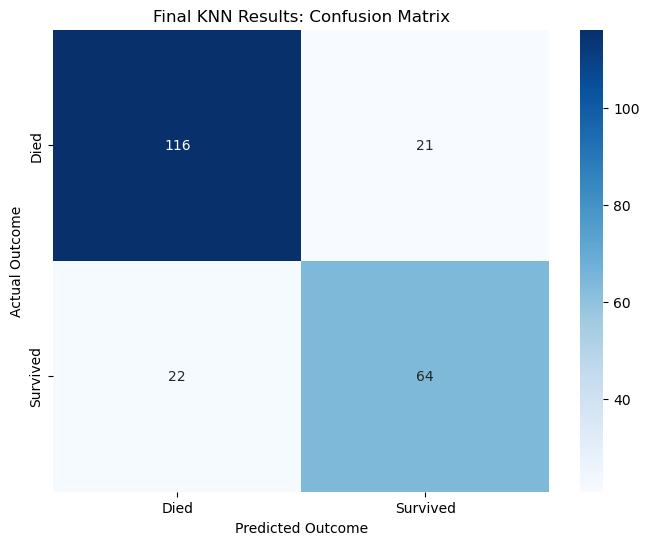

In [56]:

cm = confusion_matrix(y_test_final, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])

plt.title('Final KNN Results: Confusion Matrix')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

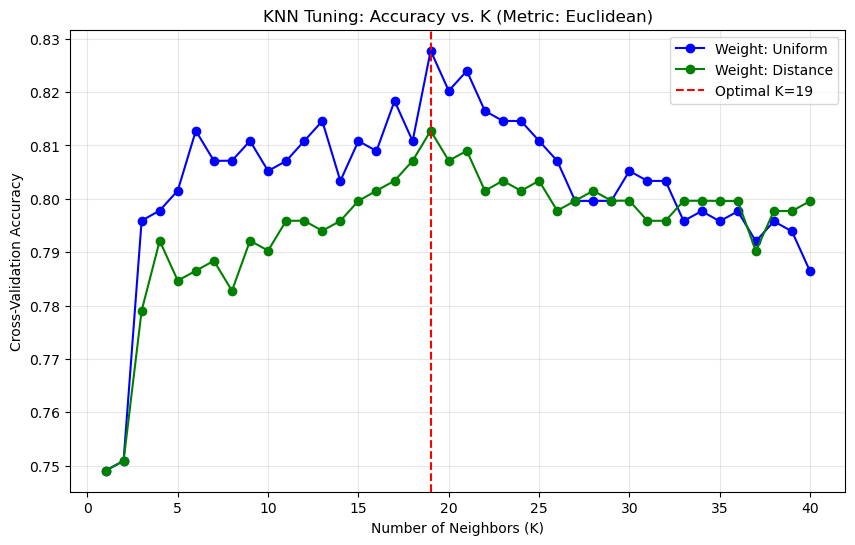

In [57]:
results = pd.DataFrame(knn_grid.cv_results_)

best_metric = knn_grid.best_params_['knn__metric']
best_k = knn_grid.best_params_['knn__n_neighbors']

plot_data = results[results['param_knn__metric'] == best_metric]

plt.figure(figsize=(10, 6))

uniform_data = plot_data[plot_data['param_knn__weights'] == 'uniform']
plt.plot(uniform_data['param_knn__n_neighbors'], uniform_data['mean_test_score'], 
         marker='o', label='Weight: Uniform', color='blue')

distance_data = plot_data[plot_data['param_knn__weights'] == 'distance']
plt.plot(distance_data['param_knn__n_neighbors'], distance_data['mean_test_score'], 
         marker='o', label='Weight: Distance', color='green')

plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal K={best_k}')
plt.title(f'KNN Tuning: Accuracy vs. K (Metric: {best_metric.capitalize()})')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ROC curve: visualizes true-positive vs. false-positive trade-offs for the tuned pipeline KNN model.

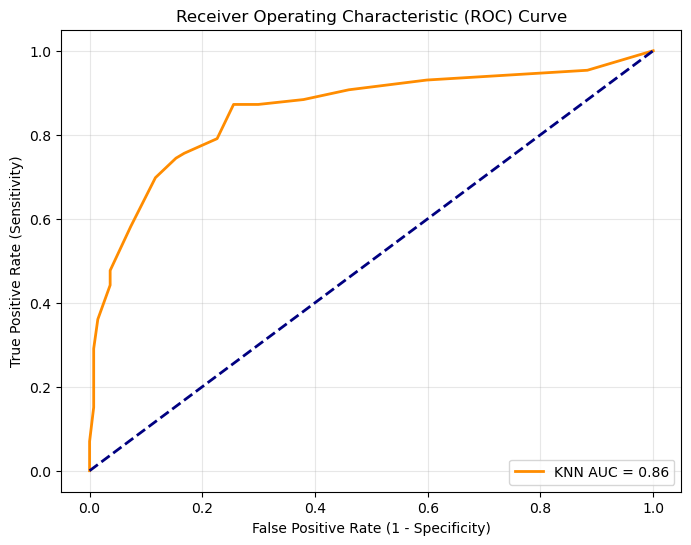

In [58]:
y_probs = knn_grid.best_estimator_.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_final, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random baseline

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


### Model Evaluation:

Pipeline KNN (K=19) achieved about 80.72% test accuracy and an AUC of ~0.85. The ROC Curve shows a high true-positive rate while keeping false positives low, indicating reliable survival predictions on this dataset.


# Section 3: Random Forest

In [59]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.0,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.0,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.0,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.0,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.0,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612


In [60]:
cat_cols = ["Pclass","Sex","Embarked","title","title_group","is_alone","Age_missing","Cabin_missing"]

for col in cat_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")
    
train.describe()

,Survived,Age,SibSp,Parch,name_length,family_size,ticket_group_size,cabin_score,name_word_count,log_Fare,log_fare_per_person,log_age_fare_ratio
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.00000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.383234,29.886234,0.464072,0.375749,26.781437,1.83982,1.757485,4.943481,4.058383,2.934821,2.584898,0.770124
std,0.486539,12.959192,0.999353,0.832877,9.302036,1.51942,1.324836,2.935730,1.171067,0.973045,0.768793,0.623685
min,0.000000,0.420000,0.000000,0.000000,12.000000,1.00000,1.000000,0.046320,3.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,20.000000,1.00000,1.000000,2.206988,3.000000,2.185579,2.169054,0.140867
50%,0.000000,29.699118,0.000000,0.000000,25.000000,1.00000,1.000000,4.986652,4.000000,2.698700,2.275315,0.809152
75%,1.000000,36.000000,1.000000,0.000000,30.000000,2.00000,2.000000,7.486077,4.000000,3.449988,3.141951,1.283346
max,1.000000,80.000000,8.000000,6.000000,82.000000,11.00000,7.000000,9.997177,14.000000,6.240917,5.406180,2.377652


In [61]:
train = train.drop(columns="title")
test = test.drop(columns="title")

In [62]:
response = train["Survived"]
predict = train.drop(columns="Survived")

response_test = test["Survived"]
predict_test = test.drop(columns="Survived")

predict = pd.get_dummies(predict, drop_first=True)
predict_test = pd.get_dummies(predict_test, drop_first=True)

Let's start by simply guessing at the hyper parameters to see how a basic fit is

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf.fit(predict, response)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

model_pred = rf.predict(predict_test)

model_proba = rf.predict_proba(predict_test)[:, 1]

print("ROC-AUC:", roc_auc_score(response_test, model_proba))
print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

ROC-AUC: 0.861441181463249
Accuracy: 0.8026905829596412
[[119  18]
 [ 26  60]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       137
           1       0.77      0.70      0.73        86

    accuracy                           0.80       223
   macro avg       0.79      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



Just a guess at a random forest model is resulting in around 80.3% prediction accuracy which is pretty good. We'll now generate importance graph to see general variable importance.

<Axes: >

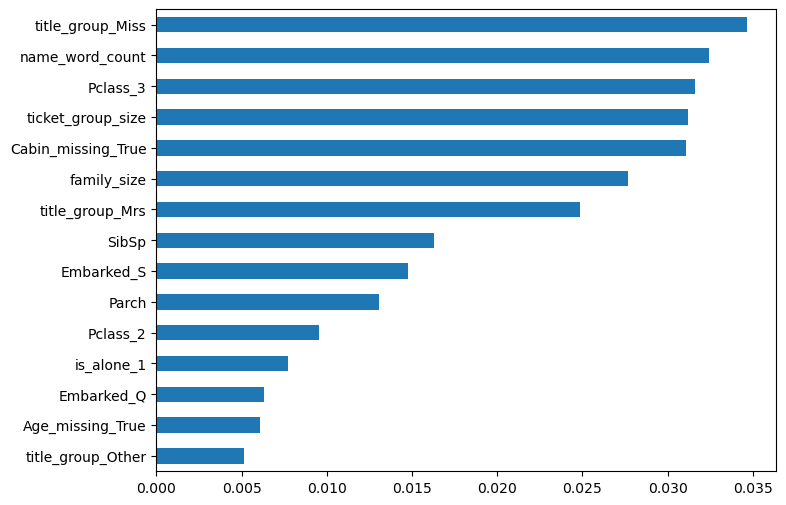

In [65]:
importance = pd.Series(
    rf.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

Could make some wild guesses right now, as women were let off first, longer names tend to denote wealthier class, pclass_3 is probably negative in that poor women survived less etc.

We'll now do some cross validation using rf's OOB estimates to save on processing power.

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

param_dist = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2"]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rand_search = RandomizedSearchCV(
  rf, param_distributions=param_dist,
  n_iter=50, cv=10, scoring='accuracy',
  n_jobs=-1, random_state=42)

rand_search.fit(predict, response)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 919}


Seems like the best params are max depth of 28, features sqrt, min leafs 3, min splits 8, and n estimators 919, we can now generate a new rf model

In [67]:
rffinal = RandomForestClassifier(
    n_estimators=919,
    max_depth=28,
    max_features="sqrt",
    min_samples_leaf=3,
    min_samples_split=8,
    random_state=42,
    n_jobs=-1
)

rffinal.fit(predict, response)

model_pred = rffinal.predict(predict_test)

model_proba = rffinal.predict_proba(predict_test)[:, 1]

print("ROC-AUC:", roc_auc_score(response_test, model_proba))
print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

ROC-AUC: 0.8605499915124767
Accuracy: 0.8071748878923767
[[118  19]
 [ 24  62]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       137
           1       0.77      0.72      0.74        86

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



The new hyper parameters improved accuracy by about 0.5%. Not too different from our initial guess but still an improvement overall.

<Axes: >

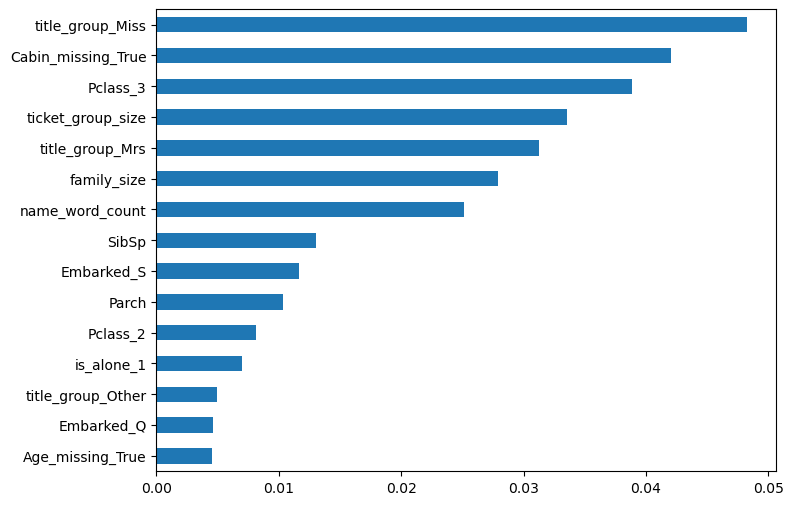

In [68]:
importance = pd.Series(
    rffinal.feature_importances_,
    index=predict.columns
).sort_values(ascending=True)

importance.head(15).plot(kind="barh", figsize=(8,6))

The importance graph is slightly different from before as well.

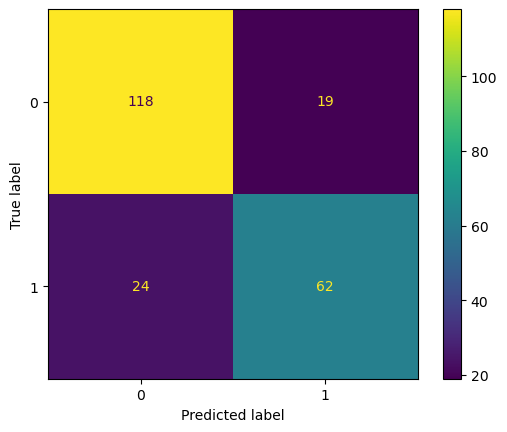

In [69]:
cm = confusion_matrix(response_test, model_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Confusion matrix doesn't look too off, there are slightly more false negatives (survived vs predicted dead) than false positives (dead vs predicted survived).

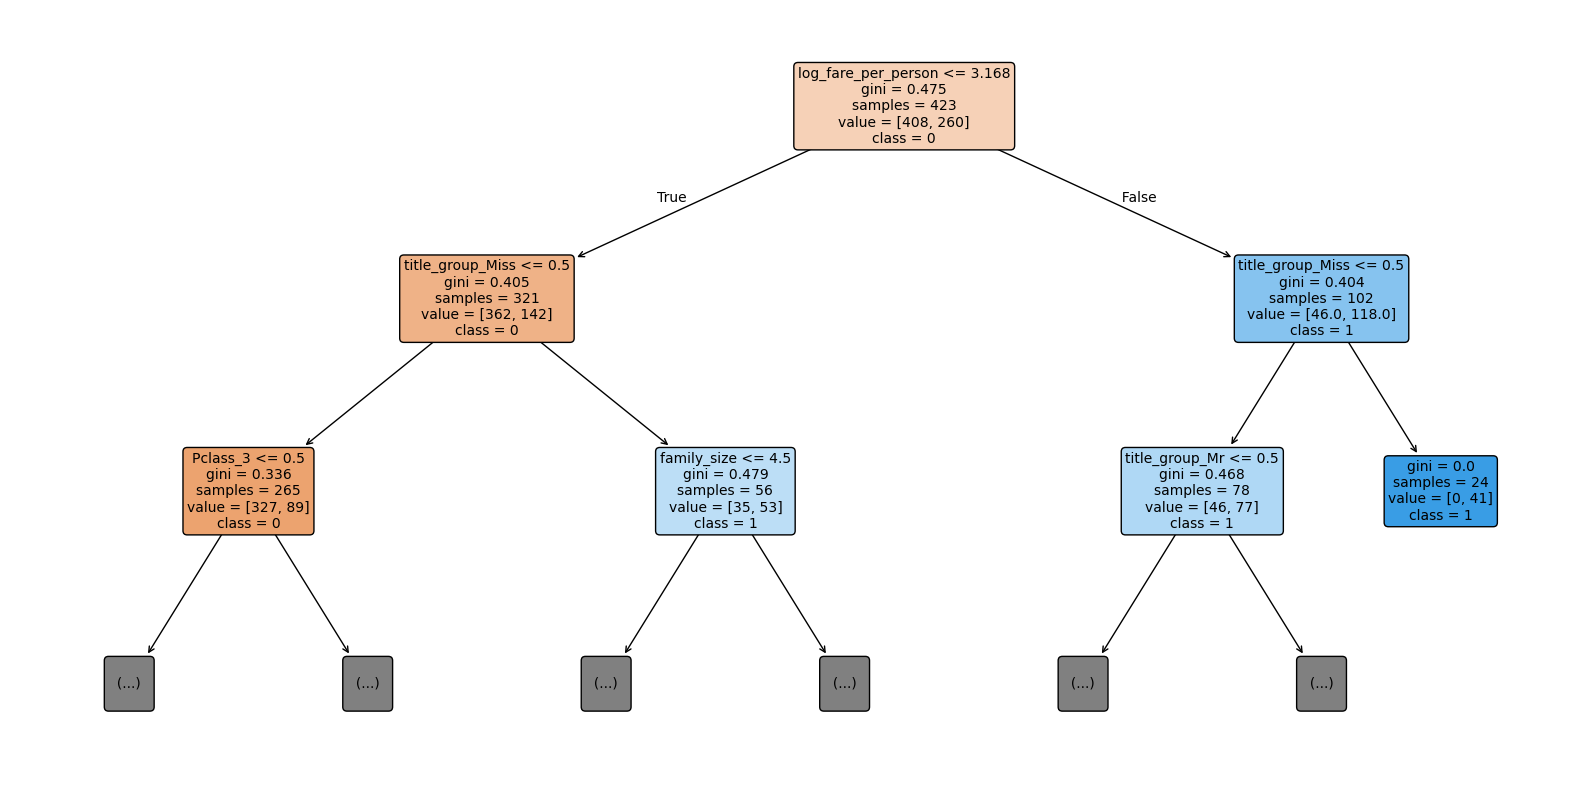

In [70]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plot_tree(
    rffinal.estimators_[0],     # pick any tree
    feature_names=predict.columns,
    class_names=rffinal.classes_.astype(str),
    max_depth=2,               # keep it shallow
    filled=True,
    rounded=True,
    fontsize=10
)

plt.show()

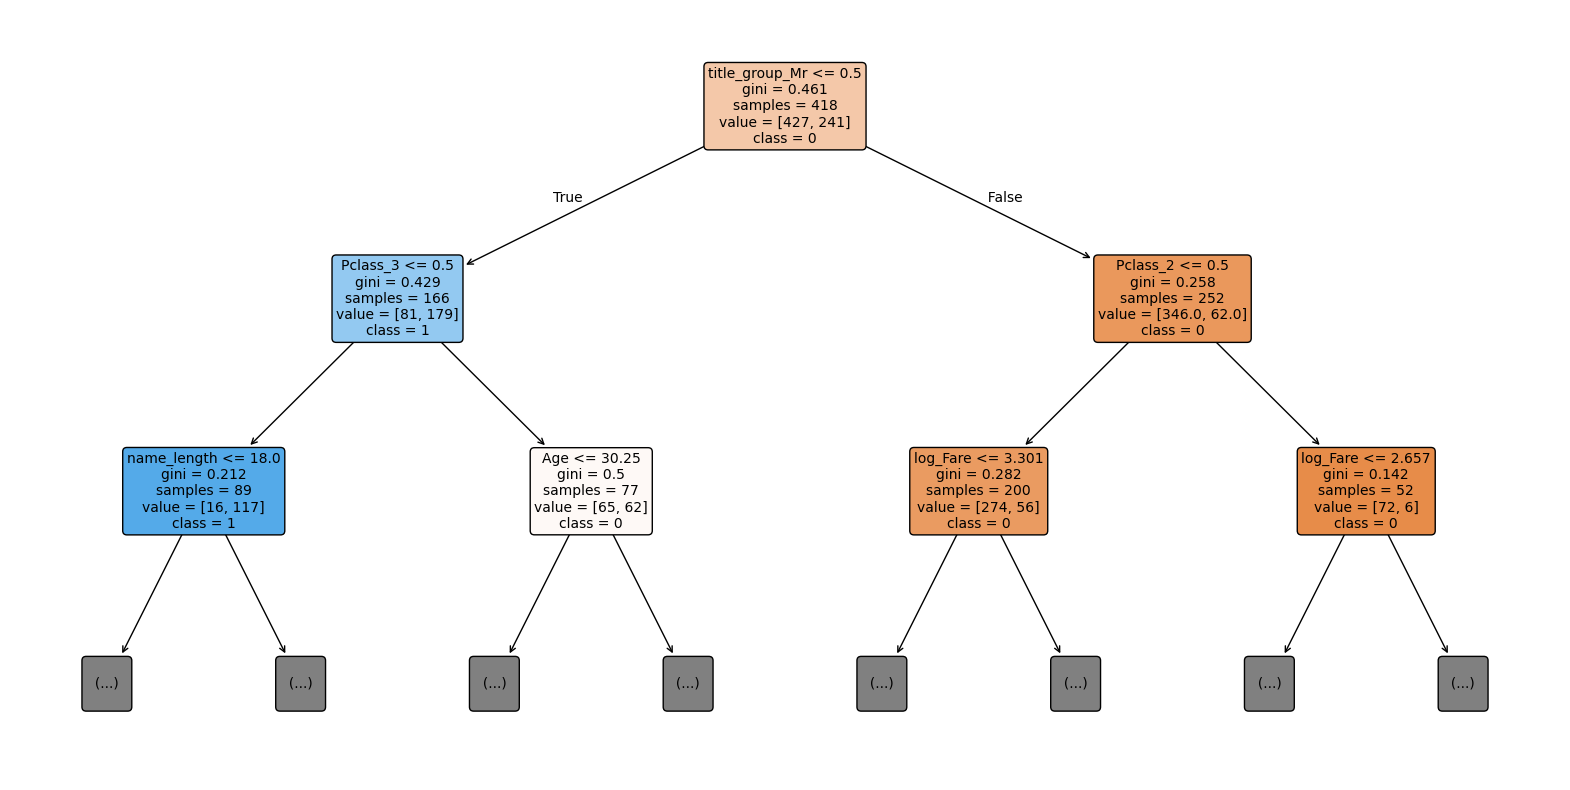

In [71]:
plt.figure(figsize=(20, 10))

plot_tree(
    rffinal.estimators_[500],     # pick any tree
    feature_names=predict.columns,
    class_names=rffinal.classes_.astype(str),
    max_depth=2,               # keep it shallow
    filled=True,
    rounded=True,
    fontsize=10
)

plt.show()

We also take a brief look at the 1st tree and the 501st tree in the model we generated, and they are different which is expected from RandomForests. We can also try gridsearchcv to see if that results in a better value. Note there's no random state as grid search tests every possibility. Warning the grid search takes like 5 minutes to run, even for so little parameters.

In [72]:
from sklearn.model_selection import GridSearchCV

param_grid={
    "n_estimators": [400, 800],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt", 0.5],
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
gs.fit(predict, response)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 5], 'min_samples_split': [2, 10], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,800


In [73]:
print("Best Parameters:", gs.best_params_)
print("Best Estimator:", gs.best_estimator_)

Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 800}
Best Estimator: RandomForestClassifier(max_features=0.5, min_samples_split=10, n_estimators=800)


In [74]:
rfgs = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42,
    bootstrap=True,
    max_features=0.5,
    n_jobs=-1
)

rfgs.fit(predict, response)

model_pred = rfgs.predict(predict_test)

model_proba = rfgs.predict_proba(predict_test)[:, 1]

print("ROC-AUC:", roc_auc_score(response_test, model_proba))
print("Accuracy:", accuracy_score(response_test, model_pred))
print(confusion_matrix(response_test, model_pred))
print(classification_report(response_test, model_pred))

ROC-AUC: 0.8530809709726701
Accuracy: 0.7892376681614349
[[119  18]
 [ 29  57]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       137
           1       0.76      0.66      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223



This one is much worse than the randomsearchcv one, even worse than base, so ignore it